In [1]:
# first check the wd
# this should be AIggregation folder, change if its not

import os

print("cwd is", os.getcwd())

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("cwd changed to", os.getcwd())


cwd is /home/tmueller/github/AIggregation/notebooks
cwd changed to /home/tmueller/github/AIggregation


In [15]:
# import fiftyone
import fiftyone as fo

# Import ortho image into fiftyone dataset type
dataset = fo.Dataset.from_images(
    ["datasets/drone_ortho/ortho_clip_23april.png"]
)


# open test image instance to verify it loaded correctly
session = fo.launch_app(dataset)

 100% |█████████████████████| 1/1 [13.6ms elapsed, 0s remaining, 84.7 samples/s] 


 100% |█████████████████████| 1/1 [26.3m elapsed, 0s remaining, 0.0 samples/s] 


09/18/2024 16:47:00 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [26.3m elapsed, 0s remaining, 0.0 samples/s] 



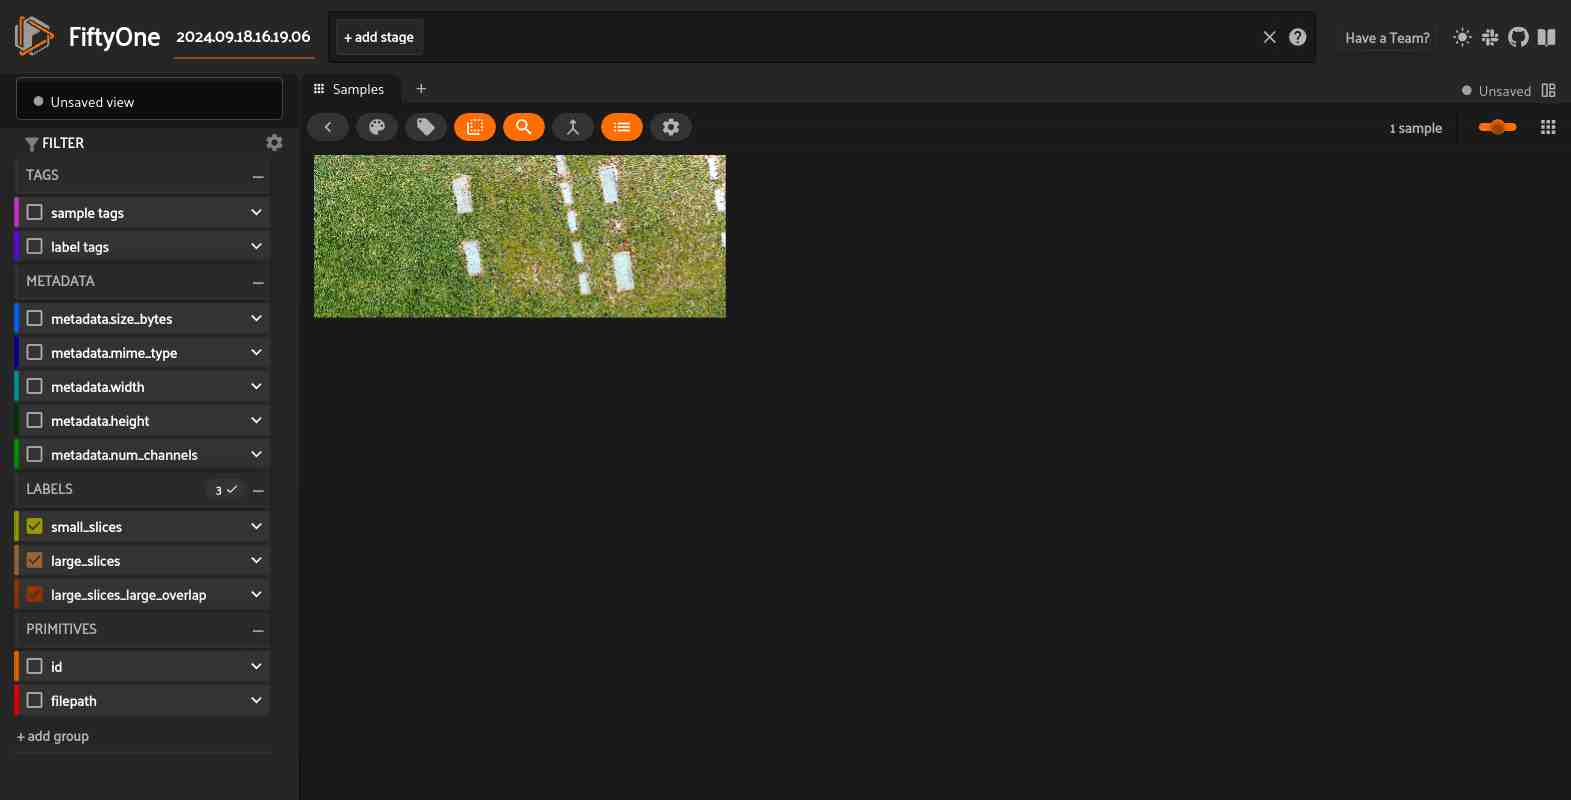

In [16]:
# import sahi 
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction


# specify AI detection model
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path='AIggregation_yolov5m/weights/best.pt', #specify path to trained model
    confidence_threshold=0.25,
    device="cpu", # or 'cuda:0'
)

# Run and compare different slicing parameters
def predict_with_slicing(sample, label_field, **kwargs):
    result = get_sliced_prediction(
        sample.filepath, detection_model, verbose=0, **kwargs
    )
    sample[label_field] = fo.Detections(detections=result.to_fiftyone_detections())


#kwargs if you want to specify many arguments that are the same for all models
#kwargs = {"overlap_height_ratio": 0.2, "overlap_width_ratio": 0.2}

kwargs = {}


for sample in dataset.iter_samples(progress=True, autosave=True):
    predict_with_slicing(sample,
                         label_field="small_slices",
                         slice_height=304,
                         slice_width=304,overlap_height_ratio = .2,
                         overlap_width_ratio=.2,
                         **kwargs
    )
    predict_with_slicing(sample,
                         label_field="large_slices",
                         slice_height=608, slice_width=608,
                         overlap_height_ratio = .2, overlap_width_ratio=.2,
                         **kwargs
    )
    predict_with_slicing(sample,
                         label_field="large_slices_large_overlap",
                         slice_height=608, slice_width=608,
                         overlap_height_ratio = .4, overlap_width_ratio=.4,
                         **kwargs
    )


#bring up new session to see boxes
session.show()

# this might take several minutes. took 26 minutes on my computer (12 threads)


In [17]:
# export the 3 different sahi predictions and save them



# first specify directories and which bounding boxes (labels) to export to each dir
# this will create those dir but fail if they already exist

small_dir = "datasets/export_predictions/small_slices"
small_label = "small_slices"  

large_dir = "datasets/export_predictions/large_slices"
large_label = "large_slices"  

largelarge_dir = "datasets/export_predictions/large_slices_large_overlap"
largelarge_label = "large_slices_large_overlap"  


#export small slice
dataset.export(
        export_dir=small_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=small_label
    )

#export large slice
dataset.export(
        export_dir=large_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=large_label
    )


#export large slice large overlap
dataset.export(
        export_dir=largelarge_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=largelarge_label
    )





 100% |█████████████████████| 1/1 [1.1s elapsed, 0s remaining, 0.9 samples/s] 


09/18/2024 17:02:46 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [1.1s elapsed, 0s remaining, 0.9 samples/s] 


 100% |█████████████████████| 1/1 [1.3s elapsed, 0s remaining, 0.8 samples/s] 


09/18/2024 17:02:47 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [1.3s elapsed, 0s remaining, 0.8 samples/s] 


 100% |█████████████████████| 1/1 [1.1s elapsed, 0s remaining, 0.9 samples/s] 


09/18/2024 17:02:48 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [1.1s elapsed, 0s remaining, 0.9 samples/s] 


In [19]:
# rearrange files to all be together before tiling

import shutil


# create a loop that goes through the 3 folders
directory = "datasets/export_predictions/"

filelist = []

# walk through folders and make a copy of JPGS and txt up 2 directories
for root, dirs, files in os.walk(directory):
    for file in files:
        filelist.append(os.path.join(root,file))
        for jpgtxtFile in filelist:
            if jpgtxtFile.endswith((".JPG", ".png", ".txt")):
                shutil.copy(jpgtxtFile, "/".join(list(jpgtxtFile.split('/')[0:-3])) )  # this splits the jpg/png/txt path at "/"" and drops the last 3 parts (moving it up 2 dir)




In [46]:



# tile the image and outputs


''' 
the exported sahi prediction can now be tiled. 

The below script takes a folder containing identically named image and txt files and tiles them into a new folder. 
This was written for yolov4 format which is slightly different but works for this itll just warn of no Class file and output all files into a single folder

'''

# but first set max image to your image size
# otherwise python thinks its a bomb DOS attack if its too large

from PIL import Image
Image.MAX_IMAGE_PIXELS = 349501440



# run yolo_tile script
%run scripts/yolo_tile.py -source ./datasets/export_predictions/large_slices -target ./datasets/tiled_export/tiles/large_slices -ext .png -falsefolder ./datasets/tiled_export/tiles/large_slices -size 608 -ratio 0.8
%run scripts/yolo_tile.py -source ./datasets/export_predictions/small_slices -target ./datasets/tiled_export/tiles/small_slices -ext .png -falsefolder ./datasets/tiled_export/tiles/small_slices -size 608 -ratio 0.8
%run scripts/yolo_tile.py -source ./datasets/export_predictions/large_slices_large_overlap -target ./datasets/tiled_export/tiles/large_slices_large_overlap -ext .png -falsefolder ./datasets/tiled_export/tiles/large_slices_large_overlap -size 608 -ratio 0.8



# the ratio creates txt files listing a random list of the tiles  in each set (test/train)

'''
    PARAMETERS:

    -source         Source folder with images and labels needed to be tiled. Default: ./yolosample/ts/
    -target         Target folder for a new sliced dataset. Default: ./yolosliced/ts/
    -ext            Image extension in a dataset. Default: .JPG
    -falsefolder    Folder for tiles without bounding boxes
    -size           Size of a tile. Default: 416
    -ratio          Train/test split ratio. Dafault: 0.8 (i.e. 80% in train)
'''


# write a yaml file for each folder

import yaml

directory = "datasets/tiled_export/tiles/"

filelist = []

folder = ["large_slices_large_overlap", "large_slices", "small_slices"]


for f in folder:
    data = {
        'names':{
        0: "nest"},
        'path': os.path.join("..", f),
        'val': "./images/"
            }
    with open((os.path.join(directory, f,"data.yaml")), 'w') as outfile:
        yaml.dump(data, outfile, default_flow_style=False, sort_keys=False)



# create new images and labels folders
import os
names = ("images","labels")
pathlist = []


for f in folder:
    path= os.path.join(directory,f)
    pathlist.append(os.path.join(path))


for name in names:
    for p in pathlist:
        newpath = (os.path.join(p, name))
        if not os.path.exists(newpath):
            os.makedirs(newpath)
            print("folder created:", newpath)




classes.names not found. It should be located one level higher than images
Image: ./datasets/export_predictions/large_slices/ortho_clip_23april.png
./datasets/tiled_export/tiles/large_slices/ortho_clip_23april_0_0.png
   class        x1        y1         w         h
0      0  0.984944  0.505938  0.026823  0.094512
./datasets/tiled_export/tiles/large_slices/ortho_clip_23april_0_1.png
   class        x1        y1        w         h
0      0  0.034395  0.505938  0.06879  0.094512
./datasets/tiled_export/tiles/large_slices/ortho_clip_23april_0_2.png
   class        x1       y1         w         h
0      0  0.516384  0.93119  0.215417  0.134331
Slice without boxes saved
./datasets/tiled_export/tiles/large_slices/ortho_clip_23april_0_4.png
   class        x1        y1         w         h
0      0  0.778193  0.712579  0.153548  0.128527
Slice without boxes saved
./datasets/tiled_export/tiles/large_slices/ortho_clip_23april_0_6.png
   class        x1        y1         w         h
0      0  0.7

In [56]:

# copies txt and image files that are in the testlist.txt file back into yolo5 format (into image and label folders)

import os 
import shutil


# I need to drop root from file names in testlist before writing to csv

directory = "datasets/tiled_export/tiles"
folder = ["large_slices_large_overlap", "large_slices", "small_slices"]

testpath = 'datasets/tiled_export/tiles/test.txt'
testwritepath = 'datasets/groundtruth_testset/testlist.txt'

testfilelist=[]
testlist =[]

# open file and read into list
with open(testpath, 'r') as fp:
    tlist = fp.read().splitlines()

# double strings to add the same list of txt
tlist.extend([w.replace('png', 'txt') for w in tlist])

# drop the root portion and only retain file names - we'll add these back for each folder later
for file in tlist:
    testfilelist.append(os.path.basename(file))

# write this to the groundtruth folder
if not os.path.exists(testwritepath):
    with open(testwritepath, "w") as output:
        for line in testfilelist:
            output.write(f"{line}\n")




# open testlist.txt
with open(testwritepath, 'r') as fp:
    testlist = fp.read().splitlines()


#and move files listed in testlist.txt to corresponding folders. These are the test dataset and should mirror the annotated test dataset (ground truth)


for f in folder:
    for item in testlist:
            if item.endswith(".png") and os.path.exists(os.path.join(directory,f, item)):
                shutil.copy(os.path.join(directory,f, item), os.path.join(directory,f, "images"))
            elif item.endswith(".txt") and os.path.exists(os.path.join(directory,f, item)):
                shutil.copy(os.path.join(directory,f, item), os.path.join(directory,f, "labels"))
    



 100% |█████████████████| 108/108 [204.3ms elapsed, 0s remaining, 532.9 samples/s] 
 100% |█████████████████| 115/115 [152.1ms elapsed, 0s remaining, 764.0 samples/s] 
 100% |█████████████████| 118/118 [151.1ms elapsed, 0s remaining, 789.3 samples/s] 
 100% |█████████████████| 118/118 [128.2ms elapsed, 0s remaining, 930.9 samples/s] 
Indexing dataset...
 100% |█████████████████| 115/115 [56.7ms elapsed, 0s remaining, 2.0K samples/s] 
Merging samples...
 118 [322.6ms elapsed, ? remaining, 367.4 samples/s] 
Indexing dataset...
 100% |█████████████████| 108/108 [61.2ms elapsed, 0s remaining, 1.8K samples/s] 
Merging samples...
 118 [596.8ms elapsed, ? remaining, 197.7 samples/s] 
Indexing dataset...
 100% |█████████████████| 118/118 [149.6ms elapsed, 0s remaining, 788.9 samples/s]     
Merging samples...
 118 [513.7ms elapsed, ? remaining, 229.7 samples/s] 



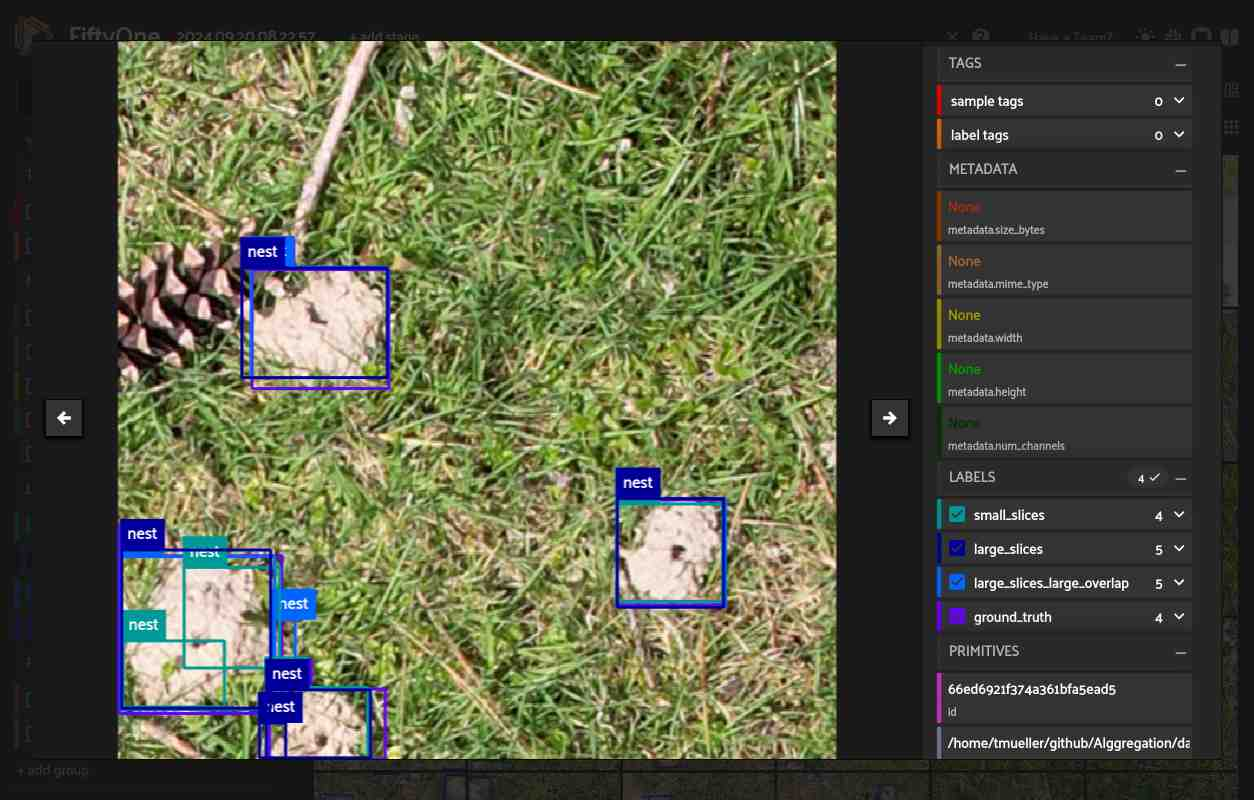

In [49]:
'''
reimport as individual fiftyone files

then merge files with different labels

HAS BEEN RUN UP TO HERE ON MY COMPUTER.
ADD AN ANNOTATED DATASET OF GROUND TRUTHS

'''

import fiftyone as fo

#then import in fiftyone


# Import annotated datasets by labels
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/tiled_export/tiles/small_slices/data.yaml",
    label_field= "small_slices"
)


dataset2 = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/tiled_export/tiles/large_slices/data.yaml",
    label_field= "large_slices"
)

dataset3 = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/tiled_export/tiles/large_slices_large_overlap/data.yaml",
    label_field= "large_slices_large_overlap"
)


dataset_ground = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/groundtruth_testset/data.yaml",
    label_field= "ground_truth"
)



# now merge the datasets, ignoring that they have different directory and merging images/labels with the same file name

key_fcn = lambda sample: os.path.basename(sample.filepath)

dataset2.merge_samples(dataset3, key_fcn=key_fcn)
dataset.merge_samples(dataset2, key_fcn=key_fcn)
dataset.merge_samples(dataset_ground, key_fcn=key_fcn)


# view that this worked
session = fo.launch_app(dataset)





In [50]:
# evaluate predictions


# evaluate the different sahi predictions
large_slice_results = dataset.evaluate_detections("large_slices", gt_field="ground_truth", eval_key="eval_large_slices")
small_slice_results = dataset.evaluate_detections("small_slices", gt_field="ground_truth", eval_key="eval_small_slices")
overlap_slice_results = dataset.evaluate_detections("large_slices_large_overlap", gt_field="ground_truth", eval_key="eval_large_slices_overlap")

# print eval results
print("-" * 50)
print("Large slice results:")
large_slice_results.print_report()

print("-" * 50)
print("Large slice overlap results:")
overlap_slice_results.print_report()

print("-" * 50)
print("Small slice results:")
small_slice_results.print_report()


Evaluating detections...
 100% |█████████████████| 118/118 [340.2ms elapsed, 0s remaining, 346.9 samples/s]      
Evaluating detections...
 100% |█████████████████| 118/118 [367.7ms elapsed, 0s remaining, 320.9 samples/s]      
Evaluating detections...
 100% |█████████████████| 118/118 [386.7ms elapsed, 0s remaining, 305.1 samples/s]      
--------------------------------------------------
Large slice results:
              precision    recall  f1-score   support

        nest       0.71      0.86      0.78       264

   micro avg       0.71      0.86      0.78       264
   macro avg       0.71      0.86      0.78       264
weighted avg       0.71      0.86      0.78       264

--------------------------------------------------
Large slice overlap results:
              precision    recall  f1-score   support

        nest       0.67      0.86      0.76       264

   micro avg       0.67      0.86      0.76       264
   macro avg       0.67      0.86      0.76       264
weighted avg   

In [55]:
# now show images where sahi is labeling false positives
# check if ground_truth labels needs to be adjusted
# for instance in this very quickly annotated test image - AI is probably outperforming me to a degree...

from fiftyone import ViewField as F

high_conf_fp_view = dataset.to_evaluation_patches(eval_key="eval_large_slices").match(F("type")=="fp").sort_by("large_slices.detection.confidence")

session.view = high_conf_fp_view.view()